### Target:

- Add rotation, 5-7 degrees should be sufficient.

### Results:

- Parameters: 7,884
- Best Training Accuracy: 99.31
- Best Test Accuracy: 99.27

### Analysis:
- Model is consistently achieving 99.15+ accuracy on 10 epochs onwards
- There is drop in accuracy from last training may be becuase of data augumentation, but we will push to next.

# Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
if 'google.colab' in sys.modules:
# Add the directory containing your module to the Python path
  module_path = '/content/drive/MyDrive/Colab_Notebooks/Session7'
  sys.path.append(module_path)
  print(sys.path)

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/Colab_Notebooks/Session7']


In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    # transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    # transforms.RandomAffine(degrees=(-7, 7), translate=(0.1, 0.1), scale=(0.09, 1.0)),
    # transforms.RandomResizedCrop((28, 28), (0.85, 1.0)),
    transforms.RandomRotation((-5., 5.), fill=1),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test Phase transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28)),
    transforms.Normalize((0.1325,), (0.3105,))
    ])


# Dataset and Creating Train/Test Split

In [5]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 51185729.61it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 40717880.28it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 32846476.86it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7386788.98it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(2.7919)
 - std: tensor(0.3053)
 - var: tensor(0.0932)
torch.Size([128, 1, 28, 28])
torch.Size([128])


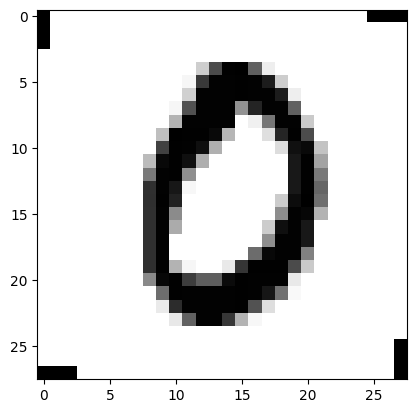

In [7]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


In [8]:
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [9]:
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=False, download=True, transform=simple_transforms)
exp_data = exp.test_data
exp_data = exp.transform(exp_data.numpy())

print('[Test]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Test]
 - Numpy Shape: (10000, 28, 28)
 - Tensor Shape: torch.Size([10000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1325)
 - std: tensor(0.3105)
 - var: tensor(0.0964)


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

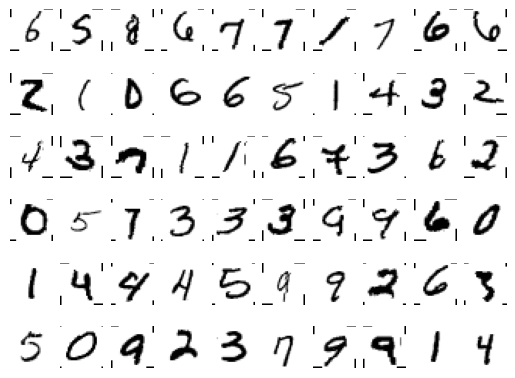

In [10]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [11]:
from models import Model9 as Net ,get_summary


# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [12]:
device = torch.device("cuda" if cuda else "cpu")
model =  Net(dropout_value=0).to(device)
get_summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 10, 24, 24]             900
              ReLU-5           [-1, 10, 24, 24]               0
       BatchNorm2d-6           [-1, 10, 24, 24]              20
            Conv2d-7           [-1, 10, 22, 22]             900
              ReLU-8           [-1, 10, 22, 22]               0
       BatchNorm2d-9           [-1, 10, 22, 22]              20
           Conv2d-10           [-1, 10, 20, 20]             900
      BatchNorm2d-11           [-1, 10, 20, 20]              20
           Conv2d-12           [-1, 10, 20, 20]             100
      BatchNorm2d-13           [-1, 10, 20, 20]              20
        MaxPool2d-14           [-1, 10,

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [13]:
from tqdm import tqdm
from utils import train,test
train_losses = []
train_acc = []
test_losses = []
test_acc = []

# Let's Train and test our model

In [14]:
model =  Net(dropout_value=0).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_acc_temp,train_losses_temp   = train(model, device, train_loader, optimizer, epoch,None)
    test_acc_temp,test_losses_temp = test(model, device, test_loader)
    train_acc.extend(train_acc_temp)
    train_losses.extend(train_losses_temp)
    test_acc.extend(test_acc_temp)
    test_losses.extend(test_losses_temp)

EPOCH: 0


Loss=0.09929096698760986 Batch_id=468 Accuracy=95.08: 100%|██████████| 469/469 [00:36<00:00, 12.70it/s]



Test set: Average loss: 0.0885, Accuracy: 9847/10000 (98.47%)

EPOCH: 1


Loss=0.04769199714064598 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:36<00:00, 12.75it/s]



Test set: Average loss: 0.0543, Accuracy: 9901/10000 (99.01%)

EPOCH: 2


Loss=0.052431147545576096 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:35<00:00, 13.13it/s]



Test set: Average loss: 0.0442, Accuracy: 9905/10000 (99.05%)

EPOCH: 3


Loss=0.031897615641355515 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:35<00:00, 13.10it/s]



Test set: Average loss: 0.0377, Accuracy: 9910/10000 (99.10%)

EPOCH: 4


Loss=0.03787410631775856 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:38<00:00, 12.21it/s]



Test set: Average loss: 0.0364, Accuracy: 9911/10000 (99.11%)

EPOCH: 5


Loss=0.02619236521422863 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:36<00:00, 12.68it/s]



Test set: Average loss: 0.0359, Accuracy: 9908/10000 (99.08%)

EPOCH: 6


Loss=0.06822650879621506 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:37<00:00, 12.65it/s]



Test set: Average loss: 0.0314, Accuracy: 9914/10000 (99.14%)

EPOCH: 7


Loss=0.02567555010318756 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:35<00:00, 13.05it/s]



Test set: Average loss: 0.0281, Accuracy: 9920/10000 (99.20%)

EPOCH: 8


Loss=0.026730341836810112 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:37<00:00, 12.64it/s]



Test set: Average loss: 0.0277, Accuracy: 9925/10000 (99.25%)

EPOCH: 9


Loss=0.01734444685280323 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:36<00:00, 12.97it/s]



Test set: Average loss: 0.0256, Accuracy: 9931/10000 (99.31%)

EPOCH: 10


Loss=0.02183491922914982 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:37<00:00, 12.65it/s]



Test set: Average loss: 0.0280, Accuracy: 9917/10000 (99.17%)

EPOCH: 11


Loss=0.01613260619342327 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:36<00:00, 12.70it/s]



Test set: Average loss: 0.0241, Accuracy: 9929/10000 (99.29%)

EPOCH: 12


Loss=0.025009015575051308 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:35<00:00, 13.19it/s]



Test set: Average loss: 0.0286, Accuracy: 9925/10000 (99.25%)

EPOCH: 13


Loss=0.011879689991474152 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:36<00:00, 12.81it/s]



Test set: Average loss: 0.0256, Accuracy: 9914/10000 (99.14%)

EPOCH: 14


Loss=0.03973899409174919 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:35<00:00, 13.24it/s]



Test set: Average loss: 0.0239, Accuracy: 9927/10000 (99.27%)



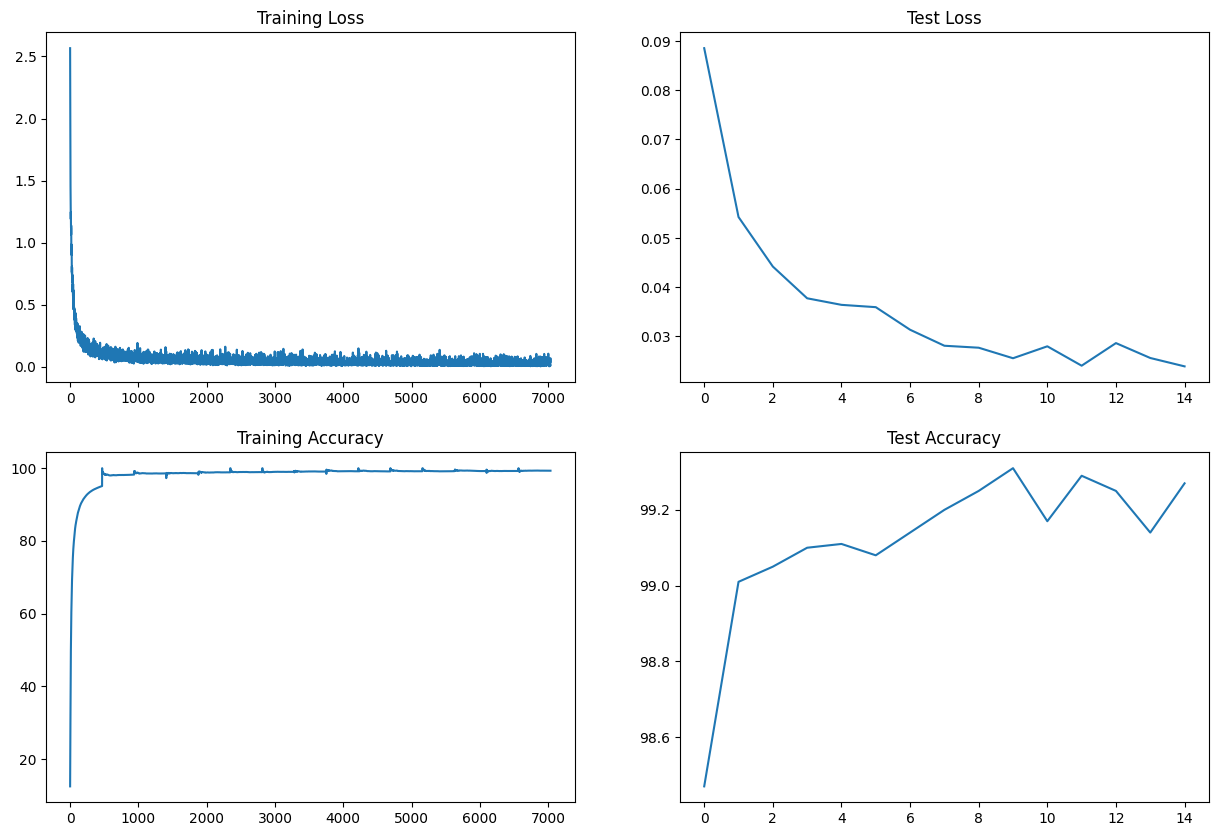

In [15]:
from utils import plot_accuracy_losses,train,test
plot_accuracy_losses(train_losses,train_acc,test_losses,test_acc)